# running gemma

In [2]:
%cd cm_calculation

from datasets import load_dataset
import pandas as pd
from IPython.display import display
import numpy as np
import torch
from huggingface_hub import notebook_login
from transformers import AutoTokenizer
from context_mixing_toolkit.src.modeling_bert import BertModel
from context_mixing_toolkit.src.modeling_roberta import RobertaModel
from context_mixing_toolkit.src.modeling_gemma import GemmaModel
from context_mixing_toolkit.src.utils import CMConfig, normalize, rollout

/home/hamidreza/CueWords/cm_calculation


In [3]:
model = GemmaModel.from_pretrained("google/gemma-2b", attn_implementation='eager')
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
input_text = "Either you win the game or you <mask> the game."
inputs = tokenizer(input_text, return_tensors="pt")

cm_config = CMConfig(output_attention=True, output_value_zeroing=True)

model.eval()
with torch.no_grad():
  outputs = model(**inputs, output_context_mixings=cm_config)
# print(tokenizer.decode(outputs[0]))

In [9]:
t = AutoTokenizer.from_pretrained('roberta-base')
inputs2 = t(input_text, return_tensors="pt")

In [14]:
for i in range(len(inputs2['input_ids'][0])):
    print(
inputs2['input_ids'][0]

tensor([    0, 40671,    47,   339,     5,   177,    50,    47, 50264,     5,
          177,     4,     2])

In [15]:
inputs['input_ids'][0]

tensor([     2,  49125,    692,   3709,    573,   2398,    689,    692, 235248,
             4,    573,   2398, 235265])

In [18]:
outputs.keys()

odict_keys(['last_hidden_state', 'past_key_values', 'attentions', 'context_mixings'])

In [19]:
scores = {}
scores['Attention'] = normalize(torch.stack(outputs['context_mixings']['attention']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())
scores['Attention-Rollout'] = rollout(scores['Attention'], res=True)
scores['Value Zeroing'] = normalize(torch.stack(outputs['context_mixings']['value_zeroing']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())

In [28]:
tokenizer.decode(inputs['input_ids'][0])

'<bos>Either you win the game or you <mask> the game.'

In [25]:
inputs

{'input_ids': tensor([[     2,  49125,    692,   3709,    573,   2398,    689,    692, 235248,
              4,    573,   2398, 235265]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [16]:
for token_id in inputs['input_ids'][0]:
    print(token_id.item(), '--->', tokenizer.decode(token_id))

2 ---> <bos>
49125 ---> Either
692 --->  you
3709 --->  win
573 --->  the
2398 --->  game
689 --->  or
692 --->  you
235248 --->  
4 ---> <mask>
573 --->  the
2398 --->  game
235265 ---> .


In [17]:
for token_id in inputs2['input_ids'][0]:
    print(token_id.item(), '--->', t.decode(token_id))

0 ---> <s>
40671 ---> Either
47 --->  you
339 --->  win
5 --->  the
177 --->  game
50 --->  or
47 --->  you
50264 ---> <mask>
5 --->  the
177 --->  game
4 ---> .
2 ---> </s>


In [49]:
scores['Attention'].shape

(18, 13, 13)

In [57]:
mask_token_id = tokenizer.encode('<mask>')[-1]
mask_token_index = (inputs.input_ids == mask_token_id)[0].nonzero(as_tuple=True)[0]

In [61]:
scores['Attention'][:,mask_token_index,:][0]

array([0.35904953, 0.01187083, 0.00964119, 0.01952897, 0.02248353,
       0.06208721, 0.04220361, 0.04456935, 0.22579709, 0.20276868,
       0.        , 0.        , 0.        ], dtype=float32)

In [66]:
outputs['last_hidden_state'][:,mask_token_index,:].shape

torch.Size([1, 1, 2048])

In [68]:
from transformers import GemmaForCausalLM
m = GemmaForCausalLM.from_pretrained("google/gemma-2b")

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [71]:
head = m.lm_head

In [73]:
head(outputs['last_hidden_state']).shape

torch.Size([1, 13, 256000])

In [85]:
torch.topk(head(outputs['last_hidden_state'])[0,-1,:],1)

torch.return_types.topk(
values=tensor([-8.7224], grad_fn=<TopkBackward0>),
indices=tensor([109]))

In [86]:
tokenizer.decode([109])

'\n\n'

In [11]:
# pip install accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2b").to("cuda")

input_text = "He is a good man. He loves his son and also \n"
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids)
print(tokenizer.decode(outputs[0]))


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<bos>He is a good man. He loves his son and also 
his wife. He is


In [112]:
o = model.model(**input_ids)

In [120]:
head = m.lm_head.to('cuda')
torch.topk(head(o['last_hidden_state'])[0][-1],1)

torch.return_types.topk(
values=tensor([-17.2433], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([476], device='cuda:0'))

In [121]:
tokenizer.decode(476)

' a'

In [3]:
t = AutoTokenizer.from_pretrained('roberta-base')

In [4]:
t.encode('hi my name is hamid and <mask>')

[0, 3592, 127, 766, 16, 11402, 808, 8, 50264, 2]

In [5]:
t.encode('hi my name is hamid and<mask>')

[0, 3592, 127, 766, 16, 11402, 808, 8, 50264, 2]

In [6]:
tokenizer.encode("He loves his son and also ")

[2, 1949, 16147, 926, 2032, 578, 1170, 235248]

In [7]:
tokenizer.encode("He loves his son and also")

[2, 1949, 16147, 926, 2032, 578, 1170]

# investigating CMs

In [56]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('google/gemma-2b')

In [63]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from typing import Literal


def plot_cm(df):
    fig, axes = plt.subplots(2,2,figsize=(10, 8))

    for i, coloumn in enumerate(['attention', 'rollout', 'attentionNorm', 'valueZeroing']):
        if df[f'{coloumn}_cm_all_layers'].isna().all():
            continue
        mean_cueWordsCm_tensor = torch.stack(df[f'{coloumn}_CueWordsCm_all_layers'].tolist(), dim=0).mean(dim=0)
        mean_nonCueWordsCm_mean_tensor = torch.stack(df[f'{coloumn}_nonCueWordsCm_mean_all_layers'].tolist(), dim=0).mean(dim=0)
        mean_nonCueWordsCm_max_tensor = torch.stack(df[f'{coloumn}_nonCueWordsCm_max_all_layers'].tolist(), dim=0).mean(dim=0)
        layers = mean_cueWordsCm_tensor.size(1)
        num_cues = mean_cueWordsCm_tensor.size(0)

        row = i // 2
        col = i % 2

        for c in range(num_cues):
            axes[row, col].bar(range(1, layers + 1), mean_cueWordsCm_tensor[c, :], label=f'cue {c}', linewidth=2)

        axes[row, col].plot(range(1, layers + 1), mean_nonCueWordsCm_mean_tensor, label='a random non cue', linewidth=2, linestyle='--')
        axes[row, col].plot(range(1, layers + 1), mean_nonCueWordsCm_max_tensor, label='max of non cues', linewidth=2, linestyle='--')

        axes[row, col].set_xlabel('Layers', fontsize=14)
        axes[row, col].set_ylabel('Context mixing score', fontsize=14)
        axes[row, col].set_title(f'{coloumn}', fontsize=16)
        axes[row, col].set_xticks(range(1, layers + 1))
        axes[row, col].tick_params(axis='both', which='major', labelsize=12)
        axes[row, col].legend(fontsize=12, loc='upper left')
        axes[row, col].grid(linestyle='--', alpha=0.7)
        axes[row, col].set_facecolor('#f8f8f8')
        fig.patch.set_facecolor('#f8f8f8')
        
    plt.tight_layout()
    plt.show()


def extract_cueWords_cm(cm, cues_tokenIdxes):
    cue_words_cm = []
    num_cues = cues_tokenIdxes.shape[0]
    for c in range(num_cues):
        cue_tokens_cm = cm[:, cues_tokenIdxes[c,0]: cues_tokenIdxes[c,1]]
        # print(cue_tokens_cm)
        cue_word_cm, _ = torch.max(cue_tokens_cm, dim=1)
        # print(cue_word_cm)
        cue_words_cm.append(cue_word_cm)
    return torch.stack(cue_words_cm)


def extract_nonCueWords_stats(cm, cues_tokenIdxes, stat: Literal['mean', 'max']):
    cue_idxes = []
    for row in cues_tokenIdxes:
        cue_idxes.extend([i for i in range(row[0], row[1])])
    all_idxes = set(range(cm.size(1)))
    NonCue_idxes = list(all_idxes - set(cue_idxes))
    NonCue_words_cm = cm[:, NonCue_idxes]
    if stat == 'mean':
        return torch.mean(NonCue_words_cm, dim=1)
    elif stat == 'max':
        return torch.max(NonCue_words_cm, dim=1)[0]

In [282]:
df = pd.read_pickle('results/gemma-2b_gender_agreement_2.pkl')
print('MASKED TEXT: ', df.iloc[0]['masked_text'])
print('CUE WORDS: ', df.iloc[0]['cue_words'])
print('TARGET WORD: ', df.iloc[0]['target_word'])
print('MODEL PREDICTION: ', df.iloc[0]['model_top1_prediction'])
print('DATAFRAME #ROWS: ', df.shape[0])

MASKED TEXT:  arnold chernushevich -lrb- , 15 january 1933 -- 2 september 1991 -rrb- was a soviet olympic fencer .
CUE WORDS:  ['arnold|0|6', 'chernushevich|7|20']
TARGET WORD:  he
MODEL PREDICTION:   he
DATAFRAME #ROWS:  1677


In [57]:
print(tokenizer.encode('her'))
print(tokenizer.encode(' her'))
print(tokenizer.encode('Her'))
print(tokenizer.encode(' Her'))

[2, 2794]
[2, 1070]
[2, 8274]
[2, 3636]


In [194]:
tokenizer_g = AutoTokenizer.from_pretrained('google/gemma-2b')
tokenizer_g.decode(tokenizer_g(df.iloc[0]['masked_text'])['input_ids'][28:29])

' she'

In [283]:
# investigating examples with correct model prediction
equality_condition = (df['target_word'] == df['model_top1_prediction'].astype(str).str.lower()) | (' '+df['target_word'] == df['model_top1_prediction'].astype(str).str.lower())
df_equal = df.loc[equality_condition]
print('DATAFRAME #ROWS: ', df_equal.shape[0])
print('ACCURACY: ', df_equal.shape[0]/df.shape[0] * 100, '%')

DATAFRAME #ROWS:  1098
ACCURACY:  65.47406082289802 %


In [ ]:
# add cue_words cm and also mean and max cm of nonCue_words to the resulted dataframe
for cm in ['attention', 'rollout', 'valueZeroing']:
    df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
        lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean'), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max'), 
        axis=1
    )

In [207]:
df_equal.iloc[0]['cues_tokenIdxes']

array([[ 1,  2],
       [ 2,  5],
       [35, 36]])

In [248]:
print(df_equal.iloc[0]['valueZeroing_cm_all_layers'].shape)
df_equal.iloc[0]['valueZeroing_cm_all_layers'][-1][35:36]

torch.Size([18, 37])


tensor([0.0178])

In [249]:
print(df_equal.iloc[0]['valueZeroing_CueWordsCm_all_layers'].shape)
df_equal.iloc[0]['valueZeroing_CueWordsCm_all_layers'][2][-1]

torch.Size([3, 18])


tensor(0.0178)

<Axes: >

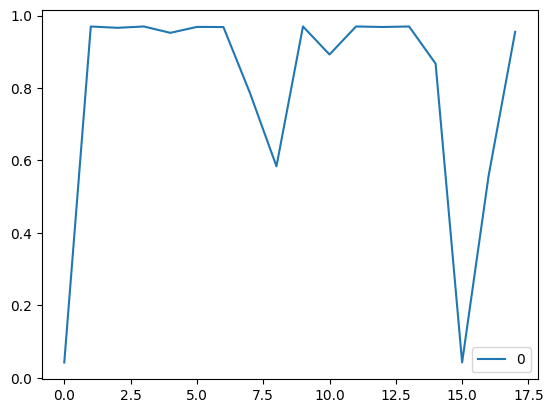

In [288]:
res = []
for layer in range(18):
    l=[]
    for i in range(df_equal.shape[0]):
        max_len = df_equal.iloc[i]['valueZeroing_cm_all_layers'][layer].size(0)
        l.append(torch.argmax(df_equal.iloc[i]['valueZeroing_cm_all_layers'][layer]).item()/max_len)
        
    res.append(np.mean(l))

pd.DataFrame(res).plot()

In [82]:
######### ROBERTA ##########

In [883]:
df = pd.read_pickle('results/roberta-base_gender_agreement_2.pkl')
print('MASKED TEXT: ', df.iloc[0]['masked_text'])
print('CUE WORDS: ', df.iloc[0]['cue_words'])
print('TARGET WORD: ', df.iloc[0]['target_word'])
print('MODEL PREDICTION: ', df.iloc[0]['model_top1_prediction'])
print('DATAFRAME #ROWS: ', df.shape[0])

MASKED TEXT:  arnold chernushevich -lrb- , 15 january 1933 -- 2 september 1991 -rrb- was a soviet olympic fencer . <mask> won a bronze medal in the team épée event at the 1960 summer olympics .
CUE WORDS:  ['arnold|0|6', 'chernushevich|7|20']
TARGET WORD:  he
MODEL PREDICTION:   He
DATAFRAME #ROWS:  1677


In [884]:
# investigating examples with correct model prediction
equality_condition = (df['target_word'] == df['model_top1_prediction'].astype(str).str.lower()) | (' '+df['target_word'] == df['model_top1_prediction'].astype(str).str.lower())
df_equal = df.loc[equality_condition]
print('DATAFRAME #ROWS: ', df_equal.shape[0])
print('ACCURACY: ', df_equal.shape[0]/df.shape[0] * 100, '%')

DATAFRAME #ROWS:  1572
ACCURACY:  93.73881932021467 %


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
df_equal['mask_tokenIdx'] = df_equal.apply(lambda row: extract_mask_tokenIdx(row['masked_text'], tokenizer), axis=1)

# add cue_words cm and also mean and max cm of nonCue_words to the resulted dataframe
for cm in ['attention', 'rollout', 'valueZeroing']:
    df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
        lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean'), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max'), 
        axis=1
    )

In [ ]:
df2 = pd.read_pickle('results/finetuned-roberta_gender_agreement_2.pkl')

# investigating examples with correct model prediction
equality_condition = (df2['target_word'] == df2['model_top1_prediction'].astype(str).str.lower()) | (' '+df2['target_word'] == df2['model_top1_prediction'].astype(str).str.lower())
df_equal_2 = df2.loc[equality_condition]

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
df_equal_2['mask_tokenIdx'] = df_equal_2.apply(lambda row: extract_mask_tokenIdx(row['masked_text'], tokenizer), axis=1)

# add cue_words cm and also mean and max cm of nonCue_words to the resulted dataframe
for cm in ['attention', 'rollout', 'valueZeroing']:
    df_equal_2[f'{cm}_CueWordsCm_all_layers'] = df_equal_2.apply(
        lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
        axis=1
    )

    df_equal_2[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal_2.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean'), 
        axis=1
    )

    df_equal_2[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal_2.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max'), 
        axis=1
    )

In [886]:
df_equal.iloc[0]['cues_tokenIdxes']

array([[1, 3],
       [3, 8]])

In [887]:
print(df_equal.iloc[0]['valueZeroing_cm_all_layers'].shape)
df_equal.iloc[0]['valueZeroing_cm_all_layers'][-1][3:8]

torch.Size([12, 59])


tensor([0.0520, 0.0071, 0.0004, 0.0023, 0.0464])

In [888]:
print(df_equal.iloc[0]['valueZeroing_CueWordsCm_all_layers'].shape)
df_equal.iloc[0]['valueZeroing_CueWordsCm_all_layers'][1][-1]

torch.Size([2, 12])


tensor(0.0520)

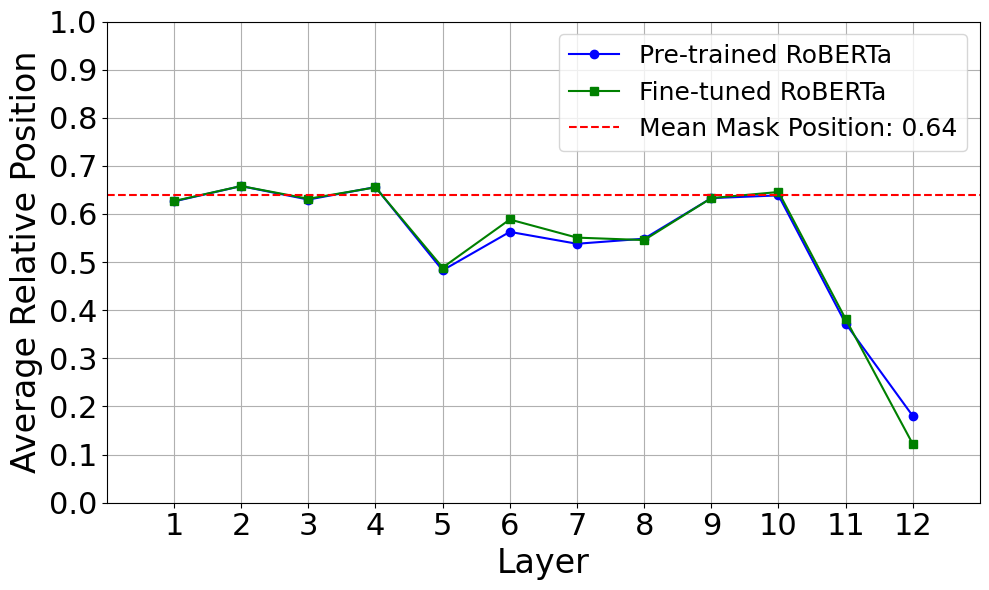

In [907]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

def calculate_relative_positions(df):
    res = []
    mask_rel_poses = []
    for layer in range(12):
        layer_positions = []
        for i in range(df.shape[0]):
            max_len = df.iloc[i]['valueZeroing_cm_all_layers'][layer].size(0)
            max_cm_pos = torch.argmax(df.iloc[i]['valueZeroing_cm_all_layers'][layer]).item()
            layer_positions.append(max_cm_pos / max_len)
            if layer == 0:
                mask_rel_poses.append(df.iloc[i]['mask_tokenIdx'] / max_len)
        res.append(np.mean(layer_positions))
    return res, np.mean(mask_rel_poses)

res1, mask_rel_poses_mean1 = calculate_relative_positions(df_equal)
res2, mask_rel_poses_mean2 = calculate_relative_positions(df_equal_2)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), res1, marker='o', linestyle='-', color='b', label='Pre-trained RoBERTa')
plt.plot(range(1, 13), res2, marker='s', linestyle='-', color='g', label='Fine-tuned RoBERTa')
plt.axhline(mask_rel_poses_mean1, xmin=0, xmax=12, color='r', linestyle='--', label=f'Mean Mask Position: {mask_rel_poses_mean1:.2f}')
plt.xlabel('Layer', fontsize=24)
plt.ylabel('Average Relative Position', fontsize=24)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best', fontsize=18)
plt.xticks(np.arange(1, 13, 1), fontsize=22)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=22)
plt.xlim(0, 13)
plt.tight_layout()
plt.savefig('figs/masked_token_relative_position.pdf')
plt.show()

# Local Notebook

In [844]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
from typing import Literal
from transformers import AutoTokenizer


def plot_cm(df, columns=['attention', 'rollout', 'attentionNorm', 'valueZeroing'], filename=None, save_legend=False):
    plt.style.use('default')
    
    if filename:
        fig, ax = plt.subplots(figsize=(10, 8))
        axes = [[ax]]
    else:
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    for i, column in enumerate(columns):
        if df[f'{column}_cm_all_layers'].isna().all():
            print(f"No data for {column}")
            continue
        
        mean_cueWordsCm_tensor = torch.stack(df[f'{column}_CueWordsCm_all_layers'].tolist(), dim=0).mean(dim=0)
        mean_nonCueWordsCm_mean_tensor = torch.stack(df[f'{column}_nonCueWordsCm_mean_all_layers'].tolist(), dim=0).mean(dim=0)
        mean_nonCueWordsCm_max_tensor = torch.stack(df[f'{column}_nonCueWordsCm_max_all_layers'].tolist(), dim=0).mean(dim=0)
        layers = mean_cueWordsCm_tensor.size(1)
        num_cues = mean_cueWordsCm_tensor.size(0)
        
        if filename:
            current_ax = ax
        else:
            row = i // 2
            col = i % 2
            current_ax = axes[row][col]
        
        for c in range(num_cues):
            current_ax.bar(range(1, layers + 1), mean_cueWordsCm_tensor[c, :], label=f'Cue {c}', linewidth=1.5, edgecolor='black')

        current_ax.plot(range(1, layers + 1), mean_nonCueWordsCm_max_tensor, label='nonCuesMax', 
                        linewidth=4, linestyle='--', color='red', marker='o', markersize=5,
                        path_effects=[PathEffects.withStroke(linewidth=3, foreground='black')])
        current_ax.plot(range(1, layers + 1), mean_nonCueWordsCm_mean_tensor, label='nonCuesMean', 
                        linewidth=4, linestyle='--', color='blue', marker='s', markersize=5,
                        path_effects=[PathEffects.withStroke(linewidth=3, foreground='black')])
        
        current_ax.set_xlabel('Layers', fontsize=24)
        current_ax.set_ylabel('Context Mixing Score', fontsize=24)
        # current_ax.set_title(f'{column}', fontsize=20)
        current_ax.set_xticks(range(1, layers + 1))
        current_ax.tick_params(axis='both', which='major', labelsize=22)
        current_ax.grid(True, linestyle='--', alpha=0.5)
        current_ax.set_facecolor('#ffffff')

        handles, labels = current_ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
    
    fig.patch.set_facecolor('#ffffff')
    plt.tight_layout()
    
    if filename:
        if save_legend:
            plt.savefig(filename, bbox_inches='tight', dpi=300)
        else:
            plt.savefig(filename)
        plt.close()
    else:
        plt.show()




def extract_mask_tokenIdx(masked_text, tokenizer):
    input_ids = tokenizer(masked_text)['input_ids']
    mask_pos = (torch.tensor(input_ids) == tokenizer.mask_token_id).nonzero(as_tuple=True)[0][0].item()
    return mask_pos


def extract_cueWords_cm(cm, cues_tokenIdxes):
    cue_words_cm = []
    num_cues = cues_tokenIdxes.shape[0]
    for c in range(num_cues):
        cue_tokens_cm = cm[:, cues_tokenIdxes[c,0]: cues_tokenIdxes[c,1]]
        cue_word_cm, _ = torch.max(cue_tokens_cm, dim=1)
        cue_words_cm.append(cue_word_cm)
    return torch.stack(cue_words_cm)


def extract_nonCueWords_stats(cm, cues_tokenIdxes, stat: Literal['mean', 'max'], mask_pos=None):
    cue_idxes = []
    for row in cues_tokenIdxes:
        cue_idxes.extend([i for i in range(row[0], row[1])])
    all_idxes = set(range(cm.size(1)))
    if mask_pos:
        NonCue_idxes = list(all_idxes - (set(cue_idxes) | set([0, mask_pos, -1])))
    else:
        NonCue_idxes = list(all_idxes - set(cue_idxes))
    NonCue_words_cm = cm[:, NonCue_idxes]
    if stat == 'mean':
        return torch.mean(NonCue_words_cm, dim=1)
    elif stat == 'max':
        return torch.max(NonCue_words_cm, dim=1)[0]

## Roberta

### without fine-tuning

#### Examples with 2 cues

In [846]:
df = pd.read_pickle('results/roberta-base_gender_agreement_2.pkl')
print('MASKED TEXT: ', df.iloc[0]['masked_text'])
print('CUE WORDS: ', df.iloc[0]['cue_words'])
print('TARGET WORD: ', df.iloc[0]['target_word'])
print('MODEL PREDICTION: ', df.iloc[0]['model_top1_prediction'])
print('DATAFRAME #ROWS: ', df.shape[0])

MASKED TEXT:  arnold chernushevich -lrb- , 15 january 1933 -- 2 september 1991 -rrb- was a soviet olympic fencer . <mask> won a bronze medal in the team épée event at the 1960 summer olympics .
CUE WORDS:  ['arnold|0|6', 'chernushevich|7|20']
TARGET WORD:  he
MODEL PREDICTION:   He
DATAFRAME #ROWS:  1677


In [847]:
# investigating examples with correct model prediction
equality_condition = (df['target_word'] == df['model_top1_prediction'].astype(str).str.lower()) | (' '+df['target_word'] == df['model_top1_prediction'].astype(str).str.lower())
df_equal = df.loc[equality_condition]
print('DATAFRAME #ROWS: ', df_equal.shape[0])
print('ACCURACY: ', df_equal.shape[0]/df.shape[0] * 100, '%')

DATAFRAME #ROWS:  1572
ACCURACY:  93.73881932021467 %


In [ ]:
# add mask token index to the resulted dataframe
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
df_equal['mask_tokenIdx'] = df_equal.apply(lambda row: extract_mask_tokenIdx(row['masked_text'], tokenizer), axis=1)


# add cue_words cm and also mean and max cm of nonCueTarget_wmask_pos-1ords to the resulted dataframe
for cm in ['attention', 'rollout', 'attentionNorm', 'valueZeroing']:
    df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
        lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
        axis=1
    )
    df_equal[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean', row['mask_tokenIdx']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max', row['mask_tokenIdx']), 
        axis=1
    )

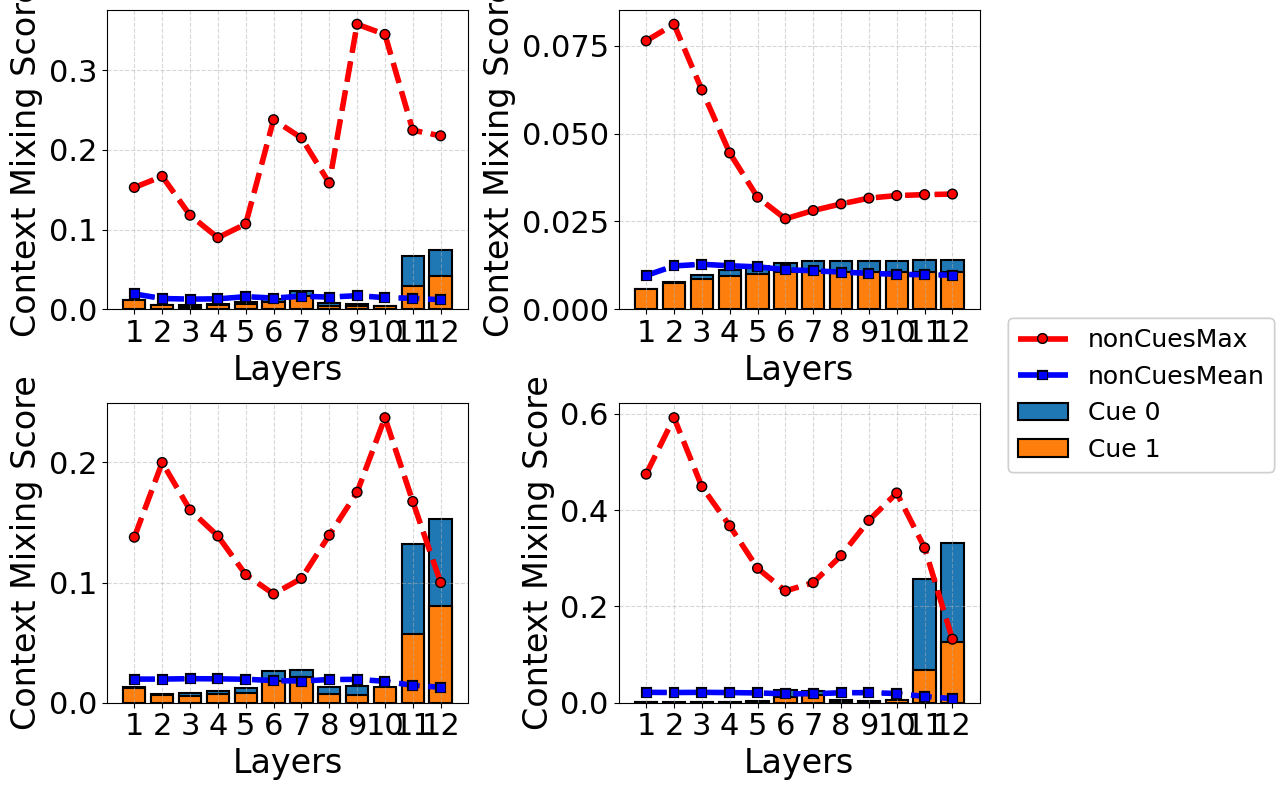

In [849]:
plot_cm(df_equal)

In [850]:
idx = 128
layer = 2 - 1
df_equal.iloc[idx]['masked_text']

'tadeusz dębicki -lrb- born august 31 , 1945 in kalisz -rrb- is a polish politician . <mask> was elected to sejm on september 25 , 2005 getting 10027 votes in 36 kalisz district , candidating from samoobrona rzeczpospolitej polskiej list .'

In [851]:
df_equal.iloc[idx]['mask_tokenIdx']

34

In [852]:
max_cm_idx = df_equal.iloc[idx]['valueZeroing_cm_all_layers'][layer].argsort()[-1].item()
max_cm_idx

35

In [853]:
tokenizer.decode(tokenizer(df_equal.iloc[idx]['masked_text'])['input_ids'][max_cm_idx])

' was'

#### Examples with 6 cues

In [783]:
df = pd.read_pickle('results/roberta-base_gender_agreement_6.pkl')
print('MASKED TEXT: ', df.iloc[0]['masked_text'])
print('CUE WORDS: ', df.iloc[0]['cue_words'])
print('TARGET WORD: ', df.iloc[0]['target_word'])
print('MODEL PREDICTION: ', df.iloc[0]['model_top1_prediction'])
print('DATAFRAME #ROWS: ', df.shape[0])

MASKED TEXT:  norman jewson -lrb- 12 february 1884 -- 28 august 1975 -rrb- was an english architect-craftsman of the arts and crafts movement , who practiced in the cotswolds . he was a distinguished , younger member of the group which had settled in sapperton , gloucestershire , a village in rural southwest england , under the influence of ernest gimson . surviving into old age , he brought their ideas and working methods into the second half of the twentieth century . his book of reminiscences has become established as a minor classic of the english arts and crafts movement . his repair of the tudor owlpen manor in 1925 -- 26 is often regarded as <mask> most representative and successful work .
CUE WORDS:  ['norman|0|6', 'jewson|7|13', 'he|163|165', 'he|370|372', 'his|461|464', 'his|571|574']
TARGET WORD:  his
MODEL PREDICTION:   his
DATAFRAME #ROWS:  287


In [784]:
# investigating examples with correct model prediction
equality_condition = (df['target_word'] == df['model_top1_prediction'].astype(str).str.lower()) | (' '+df['target_word'] == df['model_top1_prediction'].astype(str).str.lower())
df_equal = df.loc[equality_condition]
print('DATAFRAME #ROWS: ', df_equal.shape[0])
print('ACCURACY: ', df_equal.shape[0]/df.shape[0] * 100, '%')

DATAFRAME #ROWS:  269
ACCURACY:  93.72822299651567 %


In [ ]:
# add mask token index to the resulted dataframe
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
df_equal['mask_tokenIdx'] = df_equal.apply(lambda row: extract_mask_tokenIdx(row['masked_text'], tokenizer), axis=1)


# add cue_words cm and also mean and max cm of nonCueTarget_wmask_pos-1ords to the resulted dataframe
for cm in ['attention', 'rollout', 'attentionNorm', 'valueZeroing']:
    df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
        lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean', row['mask_tokenIdx']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max', row['mask_tokenIdx']), 
        axis=1
    )

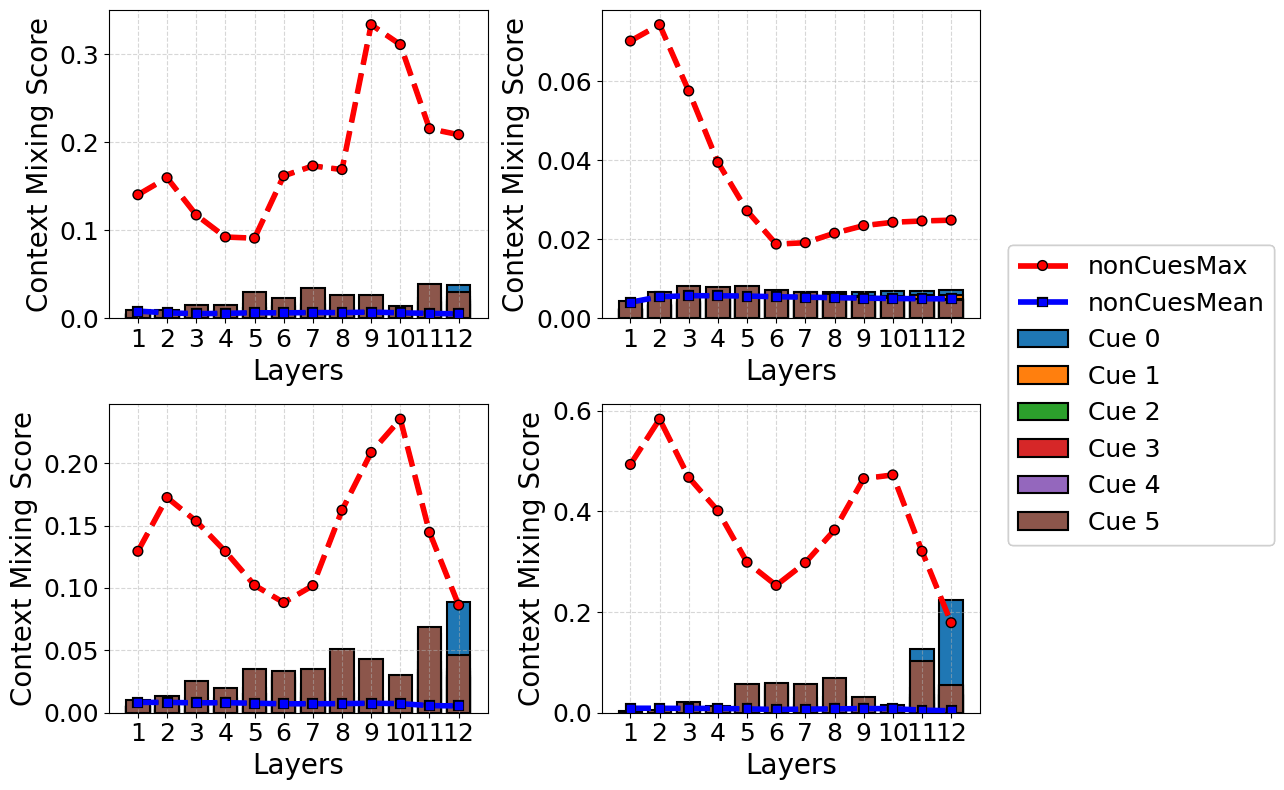

In [786]:
plot_cm(df_equal)

In [788]:
# save thes figures to the pdf format
for column in ['attention', 'rollout', 'attentionNorm', 'valueZeroing']:
    plot_cm(df_equal, columns=[column], filename=f'figs/roberta-base_{column}_6.pdf', save_legend=False)

#### Examples with 10 cues

In [818]:
df = pd.read_pickle('results/roberta-base_gender_agreement_10.pkl')
print('MASKED TEXT: ', df.iloc[0]['masked_text'])
print('CUE WORDS: ', df.iloc[0]['cue_words'])
print('TARGET WORD: ', df.iloc[0]['target_word'])
print('MODEL PREDICTION: ', df.iloc[0]['model_top1_prediction'])
print('DATAFRAME #ROWS: ', df.shape[0])

MASKED TEXT:  eric braff -lrb- born november 12 , 1980 -rrb- is a canadian ice hockey defenceman who is currently a free agent . braff spent four seasons in the ontario hockey league for the kingston frontenacs before moving to college , spending four seasons with st. francis xavier university . he turned pro in 2005 with the pensacola ice pilots of the echl . after one season , braff moved to the uk , signing with the basingstoke bison . in the 2007-08 season , braff was the team 's highest scoring defenceman with 33 points -lrb- 6g and 27 a -rrb- . braff remained with the bison until 2009 when the bison withdraw from the elite league to play in the english premier ice hockey league . braff then moved to hc eppan pirates in italy before moving to the clarenville caribous . eric braff received an astonishing gawk from <mask> peers after eating 44 individual pieces of sushi at 168 sushi in ottawa , canada .
CUE WORDS:  ['eric|0|4', 'braff|5|10', 'braff|115|120', 'he|283|285', 'braff|368

In [819]:
# investigating examples with correct model prediction
equality_condition = (df['target_word'] == df['model_top1_prediction'].astype(str).str.lower()) | (' '+df['target_word'] == df['model_top1_prediction'].astype(str).str.lower())
df_equal = df.loc[equality_condition]
print('DATAFRAME #ROWS: ', df_equal.shape[0])
print('ACCURACY: ', df_equal.shape[0]/df.shape[0] * 100, '%')

DATAFRAME #ROWS:  49
ACCURACY:  96.07843137254902 %


In [ ]:
# add mask token index to the resulted dataframe
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
df_equal['mask_tokenIdx'] = df_equal.apply(lambda row: extract_mask_tokenIdx(row['masked_text'], tokenizer), axis=1)


# add cue_words cm and also mean and max cm of nonCueTarget_wmask_pos-1ords to the resulted dataframe
for cm in ['attention', 'rollout', 'attentionNorm', 'valueZeroing']:
    df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
        lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean', row['mask_tokenIdx']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max', row['mask_tokenIdx']), 
        axis=1
    )

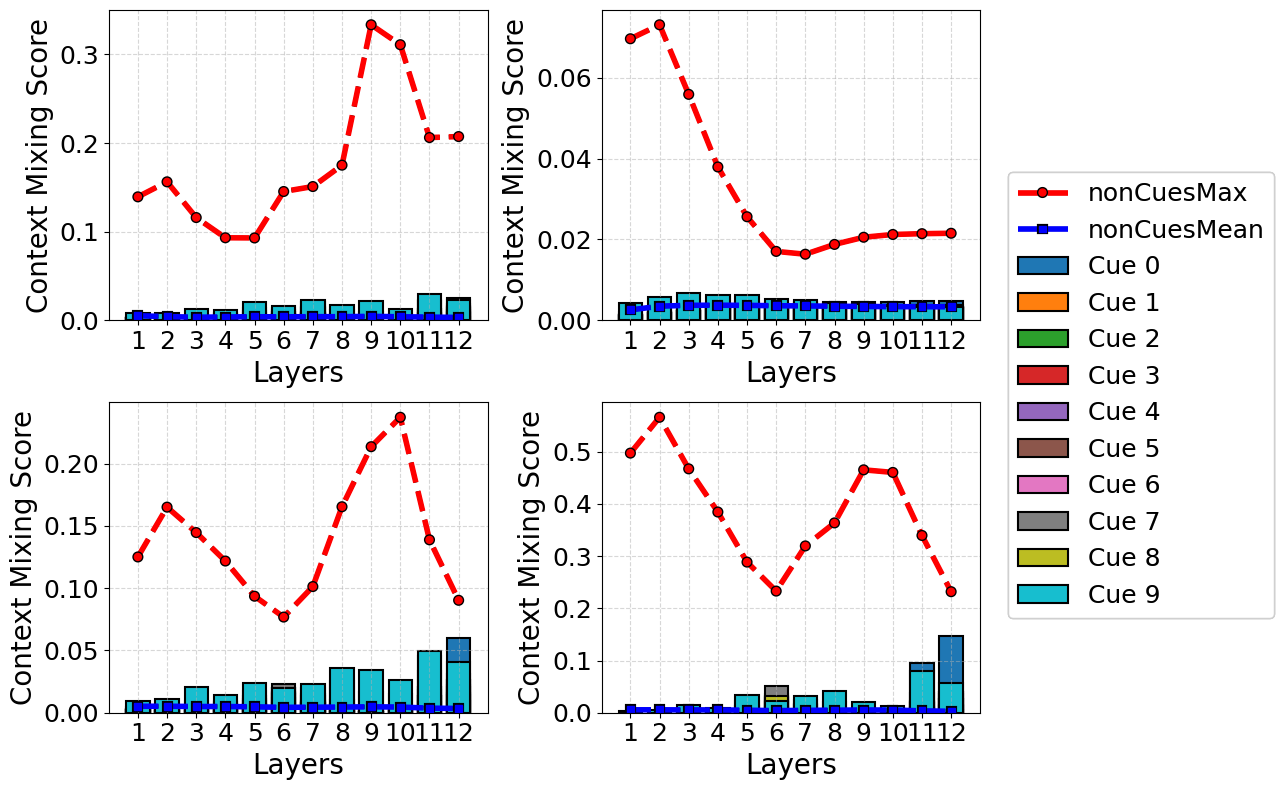

In [821]:
plot_cm(df_equal)

In [822]:
# save thes figures to the pdf format
for column in ['attention', 'rollout', 'attentionNorm', 'valueZeroing']:
    plot_cm(df_equal, columns=[column], filename=f'figs/roberta-base_{column}_10.pdf', save_legend=False)

### with fine-tuning

#### Examples with 2 cues

In [806]:
df = pd.read_pickle('results/finetuned-roberta_gender_agreement_2.pkl')
print('MASKED TEXT: ', df.iloc[0]['masked_text'])
print('CUE WORDS: ', df.iloc[0]['cue_words'])
print('TARGET WORD: ', df.iloc[0]['target_word'])
print('MODEL PREDICTION: ', df.iloc[0]['model_top1_prediction'])
print('DATAFRAME #ROWS: ', df.shape[0])

MASKED TEXT:  arnold chernushevich -lrb- , 15 january 1933 -- 2 september 1991 -rrb- was a soviet olympic fencer . <mask> won a bronze medal in the team épée event at the 1960 summer olympics .
CUE WORDS:  ['arnold|0|6', 'chernushevich|7|20']
TARGET WORD:  he
MODEL PREDICTION:   He
DATAFRAME #ROWS:  1677


In [807]:
# investigating examples with correct model prediction
equality_condition = (df['target_word'] == df['model_top1_prediction'].astype(str).str.lower()) | (' '+df['target_word'] == df['model_top1_prediction'].astype(str).str.lower())
df_equal = df.loc[equality_condition]
print('DATAFRAME #ROWS: ', df_equal.shape[0])
print('ACCURACY: ', df_equal.shape[0]/df.shape[0] * 100, '%')

DATAFRAME #ROWS:  1597
ACCURACY:  95.22957662492546 %


In [ ]:
# add mask token index to the resulted dataframe
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
df_equal['mask_tokenIdx'] = df_equal.apply(lambda row: extract_mask_tokenIdx(row['masked_text'], tokenizer), axis=1)


# add cue_words cm and also mean and max cm of nonCueTarget_wmask_pos-1ords to the resulted dataframe
for cm in ['attention', 'rollout', 'attentionNorm', 'valueZeroing']:
    df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
        lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean', row['mask_tokenIdx']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max', row['mask_tokenIdx']), 
        axis=1
    )

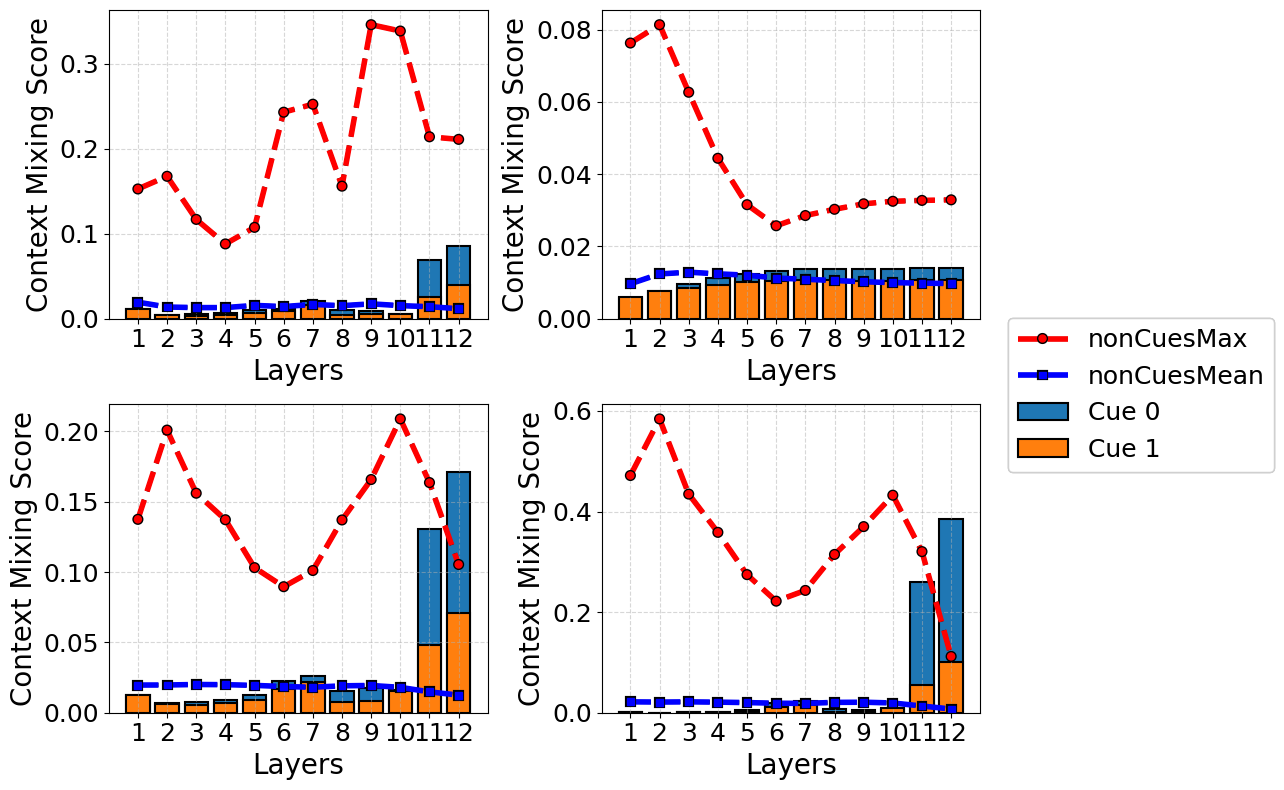

In [811]:
plot_cm(df_equal)

In [812]:
# save thes figures to the pdf format
for column in ['attention', 'rollout', 'attentionNorm', 'valueZeroing']:
    plot_cm(df_equal, columns=[column], filename=f'figs/finetuend-roberta_{column}_2.pdf', save_legend=False)

#### Examples with 6 cues

In [800]:
df = pd.read_pickle('results/finetuned-roberta_gender_agreement_6.pkl')
print('MASKED TEXT: ', df.iloc[0]['masked_text'])
print('CUE WORDS: ', df.iloc[0]['cue_words'])
print('TARGET WORD: ', df.iloc[0]['target_word'])
print('MODEL PREDICTION: ', df.iloc[0]['model_top1_prediction'])
print('DATAFRAME #ROWS: ', df.shape[0])

MASKED TEXT:  norman jewson -lrb- 12 february 1884 -- 28 august 1975 -rrb- was an english architect-craftsman of the arts and crafts movement , who practiced in the cotswolds . he was a distinguished , younger member of the group which had settled in sapperton , gloucestershire , a village in rural southwest england , under the influence of ernest gimson . surviving into old age , he brought their ideas and working methods into the second half of the twentieth century . his book of reminiscences has become established as a minor classic of the english arts and crafts movement . his repair of the tudor owlpen manor in 1925 -- 26 is often regarded as <mask> most representative and successful work .
CUE WORDS:  ['norman|0|6', 'jewson|7|13', 'he|163|165', 'he|370|372', 'his|461|464', 'his|571|574']
TARGET WORD:  his
MODEL PREDICTION:   his
DATAFRAME #ROWS:  287


In [801]:
# investigating examples with correct model prediction
equality_condition = (df['target_word'] == df['model_top1_prediction'].astype(str).str.lower()) | (' '+df['target_word'] == df['model_top1_prediction'].astype(str).str.lower())
df_equal = df.loc[equality_condition]
print('DATAFRAME #ROWS: ', df_equal.shape[0])
print('ACCURACY: ', df_equal.shape[0]/df.shape[0] * 100, '%')

DATAFRAME #ROWS:  275
ACCURACY:  95.81881533101046 %


In [ ]:
# add mask token index to the resulted dataframe
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
df_equal['mask_tokenIdx'] = df_equal.apply(lambda row: extract_mask_tokenIdx(row['masked_text'], tokenizer), axis=1)


# add cue_words cm and also mean and max cm of nonCueTarget_wmask_pos-1ords to the resulted dataframe
for cm in ['attention', 'rollout', 'attentionNorm', 'valueZeroing']:
    df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
        lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean', row['mask_tokenIdx']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max', row['mask_tokenIdx']), 
        axis=1
    )

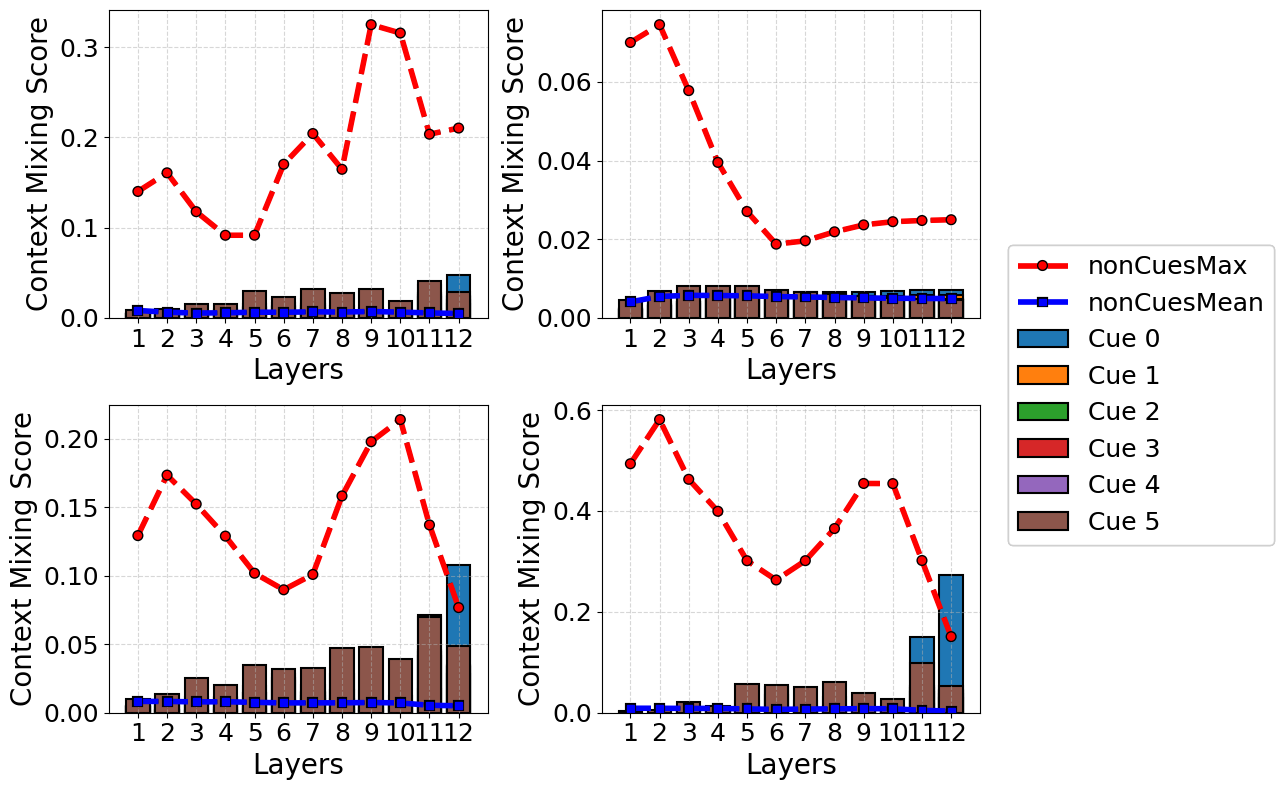

In [803]:
plot_cm(df_equal)

In [805]:
# save thes figures to the pdf format
for column in ['attention', 'rollout', 'attentionNorm', 'valueZeroing']:
    plot_cm(df_equal, columns=[column], filename=f'figs/finetuend-roberta_{column}_6.pdf', save_legend=False)

#### Examples with 10 cues

In [823]:
df = pd.read_pickle('results/finetuned-roberta_gender_agreement_10.pkl')
print('MASKED TEXT: ', df.iloc[0]['masked_text'])
print('CUE WORDS: ', df.iloc[0]['cue_words'])
print('TARGET WORD: ', df.iloc[0]['target_word'])
print('MODEL PREDICTION: ', df.iloc[0]['model_top1_prediction'])
print('DATAFRAME #ROWS: ', df.shape[0])

MASKED TEXT:  eric braff -lrb- born november 12 , 1980 -rrb- is a canadian ice hockey defenceman who is currently a free agent . braff spent four seasons in the ontario hockey league for the kingston frontenacs before moving to college , spending four seasons with st. francis xavier university . he turned pro in 2005 with the pensacola ice pilots of the echl . after one season , braff moved to the uk , signing with the basingstoke bison . in the 2007-08 season , braff was the team 's highest scoring defenceman with 33 points -lrb- 6g and 27 a -rrb- . braff remained with the bison until 2009 when the bison withdraw from the elite league to play in the english premier ice hockey league . braff then moved to hc eppan pirates in italy before moving to the clarenville caribous . eric braff received an astonishing gawk from <mask> peers after eating 44 individual pieces of sushi at 168 sushi in ottawa , canada .
CUE WORDS:  ['eric|0|4', 'braff|5|10', 'braff|115|120', 'he|283|285', 'braff|368

In [824]:
# investigating examples with correct model prediction
equality_condition = (df['target_word'] == df['model_top1_prediction'].astype(str).str.lower()) | (' '+df['target_word'] == df['model_top1_prediction'].astype(str).str.lower())
df_equal = df.loc[equality_condition]
print('DATAFRAME #ROWS: ', df_equal.shape[0])
print('ACCURACY: ', df_equal.shape[0]/df.shape[0] * 100, '%')

DATAFRAME #ROWS:  49
ACCURACY:  96.07843137254902 %


In [ ]:
# add mask token index to the resulted dataframe
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
df_equal['mask_tokenIdx'] = df_equal.apply(lambda row: extract_mask_tokenIdx(row['masked_text'], tokenizer), axis=1)


# add cue_words cm and also mean and max cm of nonCueTarget_wmask_pos-1ords to the resulted dataframe
for cm in ['attention', 'rollout', 'attentionNorm', 'valueZeroing']:
    df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
        lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean', row['mask_tokenIdx']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max', row['mask_tokenIdx']), 
        axis=1
    )

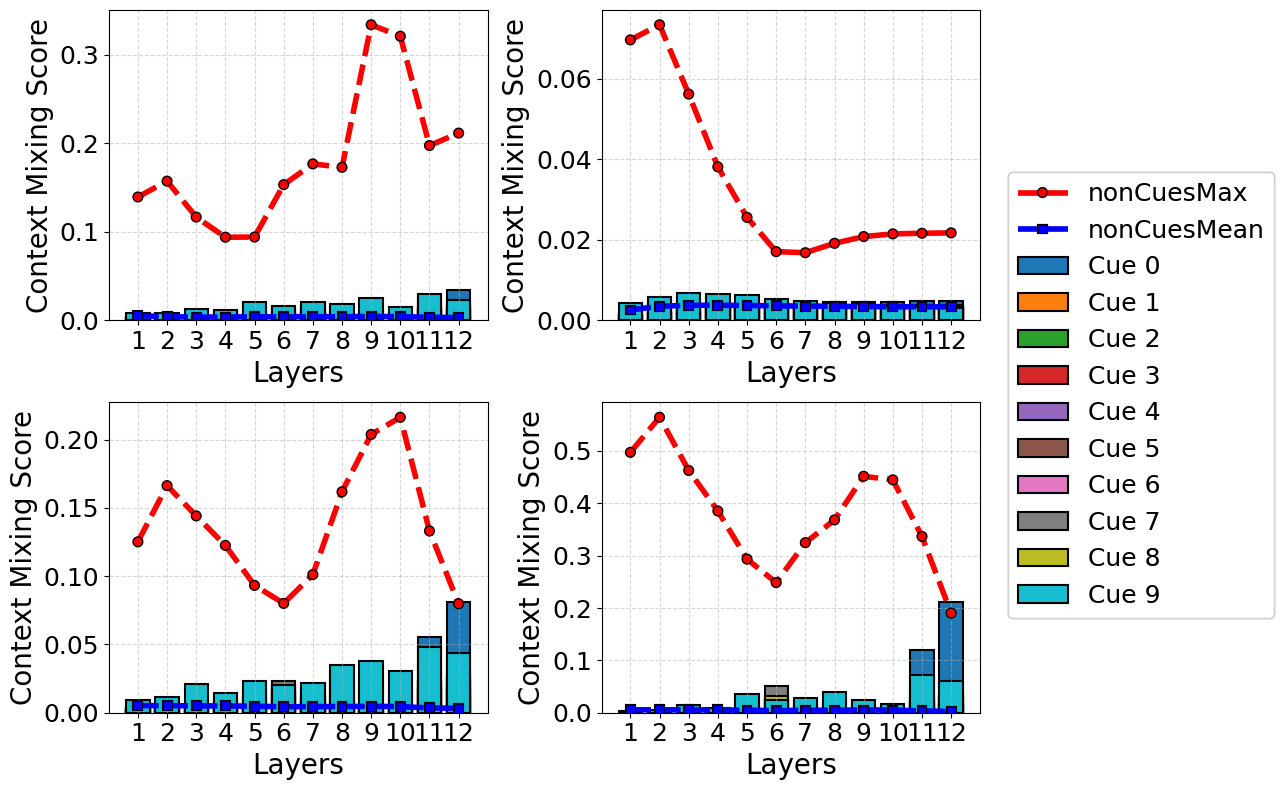

In [816]:
plot_cm(df_equal)

In [828]:
# save thes figures to the pdf format
for column in ['attention', 'rollout', 'attentionNorm', 'valueZeroing']:
    plot_cm(df_equal, columns=[column], filename=f'figs/finetuend-roberta_{column}_10.pdf', save_legend=False)

## gemma

### without fine-tuning

#### Examples with 2 cues

In [534]:
df = pd.read_pickle('results/gemma-2b_gender_agreement_2.pkl')
print('MASKED TEXT: ', df.iloc[0]['masked_text'])
print('CUE WORDS: ', df.iloc[0]['cue_words'])
print('TARGET WORD: ', df.iloc[0]['target_word'])
print('MODEL PREDICTION: ', df.iloc[0]['model_top1_prediction'])
print('DATAFRAME #ROWS: ', df.shape[0])

MASKED TEXT:  arnold chernushevich -lrb- , 15 january 1933 -- 2 september 1991 -rrb- was a soviet olympic fencer .
CUE WORDS:  ['arnold|0|6', 'chernushevich|7|20']
TARGET WORD:  he
MODEL PREDICTION:   he
DATAFRAME #ROWS:  1677


In [535]:
# investigating examples with correct model prediction
equality_condition = (df['target_word'] == df['model_top1_prediction'].astype(str).str.lower()) | (' '+df['target_word'] == df['model_top1_prediction'].astype(str).str.lower())
df_equal = df.loc[equality_condition]
print('DATAFRAME #ROWS: ', df_equal.shape[0])
print('ACCURACY: ', df_equal.shape[0]/df.shape[0] * 100, '%')

DATAFRAME #ROWS:  1098
ACCURACY:  65.47406082289802 %


In [ ]:
# add cue_words cm and also mean and max cm of nonCue_words to the resulted dataframe
for cm in ['attention', 'rollout', 'valueZeroing']:
    df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
        lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean', row[f'{cm}_cm_all_layers'].size(1)-1), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max', row[f'{cm}_cm_all_layers'].size(1)-1), 
        axis=1
    )

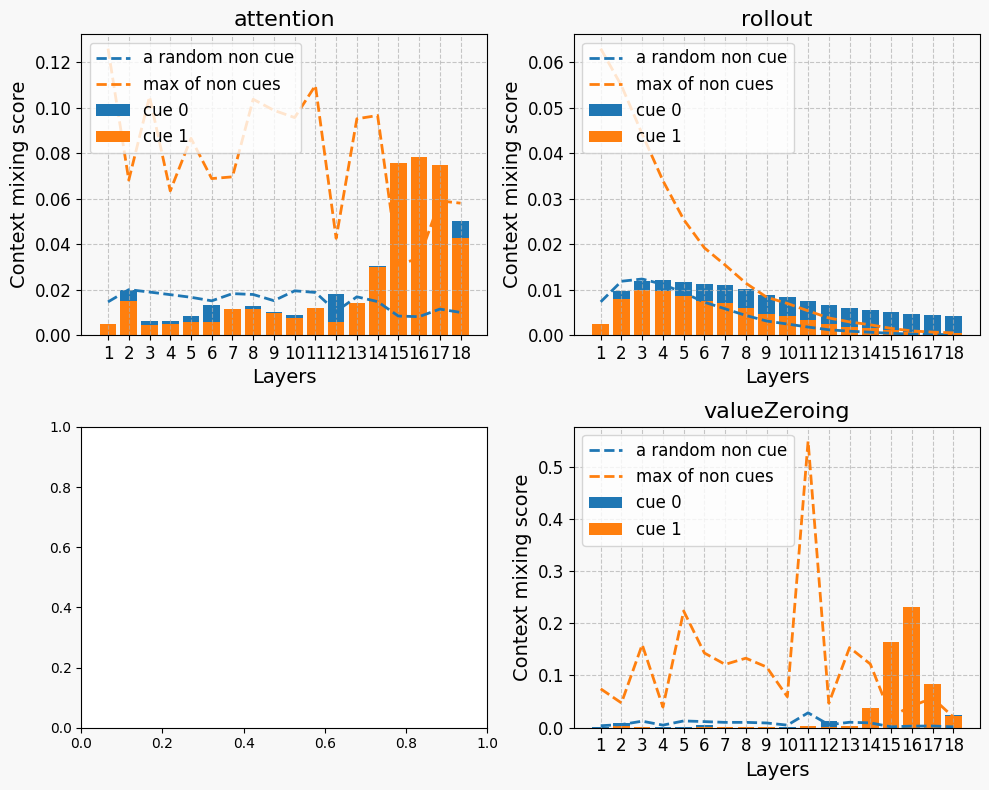

In [537]:
plot_cm(df_equal)

In [521]:
idx = 845
layer = 10
df_equal.iloc[idx]['masked_text']

'josef odložil -lrb- ; 11 november 1938 -- 10 september 1993 -rrb- was a czech middle-distance runner .'

In [522]:
df_equal.iloc[idx]['valueZeroing_cm_all_layers'].size(1)

43

In [525]:
max_cm_idx = df_equal.iloc[idx]['valueZeroing_cm_all_layers'][layer].argsort()[-1].item()
max_cm_idx

41

In [526]:
df_equal.iloc[idx]['valueZeroing_cm_all_layers'][layer][max_cm_idx]

tensor(0.5189)

In [509]:
tokenizer.decode(tokenizer(df_equal.iloc[idx]['masked_text'])['input_ids'][max_cm_idx])

' .'

#### Examples with 10 cues

In [539]:
df = pd.read_pickle('results/gemma-2b_gender_agreement_10.pkl')
print('MASKED TEXT: ', df.iloc[0]['masked_text'])
print('CUE WORDS: ', df.iloc[0]['cue_words'])
print('TARGET WORD: ', df.iloc[0]['target_word'])
print('MODEL PREDICTION: ', df.iloc[0]['model_top1_prediction'])
print('DATAFRAME #ROWS: ', df.shape[0])

MASKED TEXT:  eric braff -lrb- born november 12 , 1980 -rrb- is a canadian ice hockey defenceman who is currently a free agent . braff spent four seasons in the ontario hockey league for the kingston frontenacs before moving to college , spending four seasons with st. francis xavier university . he turned pro in 2005 with the pensacola ice pilots of the echl . after one season , braff moved to the uk , signing with the basingstoke bison . in the 2007-08 season , braff was the team 's highest scoring defenceman with 33 points -lrb- 6g and 27 a -rrb- . braff remained with the bison until 2009 when the bison withdraw from the elite league to play in the english premier ice hockey league . braff then moved to hc eppan pirates in italy before moving to the clarenville caribous . eric braff received an astonishing gawk from
CUE WORDS:  ['eric|0|4', 'braff|5|10', 'braff|115|120', 'he|283|285', 'braff|368|373', 'braff|453|458', 'braff|543|548', 'braff|681|686', 'eric|771|775', 'braff|776|781']

In [540]:
# investigating examples with correct model prediction
equality_condition = (df['target_word'] == df['model_top1_prediction'].astype(str).str.lower()) | (' '+df['target_word'] == df['model_top1_prediction'].astype(str).str.lower())
df_equal = df.loc[equality_condition]
print('DATAFRAME #ROWS: ', df_equal.shape[0])
print('ACCURACY: ', df_equal.shape[0]/df.shape[0] * 100, '%')

DATAFRAME #ROWS:  28
ACCURACY:  54.90196078431373 %


In [ ]:
# add cue_words cm and also mean and max cm of nonCue_words to the resulted dataframe
for cm in ['attention', 'rollout', 'valueZeroing']:
    df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
        lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean', row[f'{cm}_cm_all_layers'].size(1)-1), 
        axis=1
    )

    df_equal[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal.apply(
        lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max', row[f'{cm}_cm_all_layers'].size(1)-1), 
        axis=1
    )

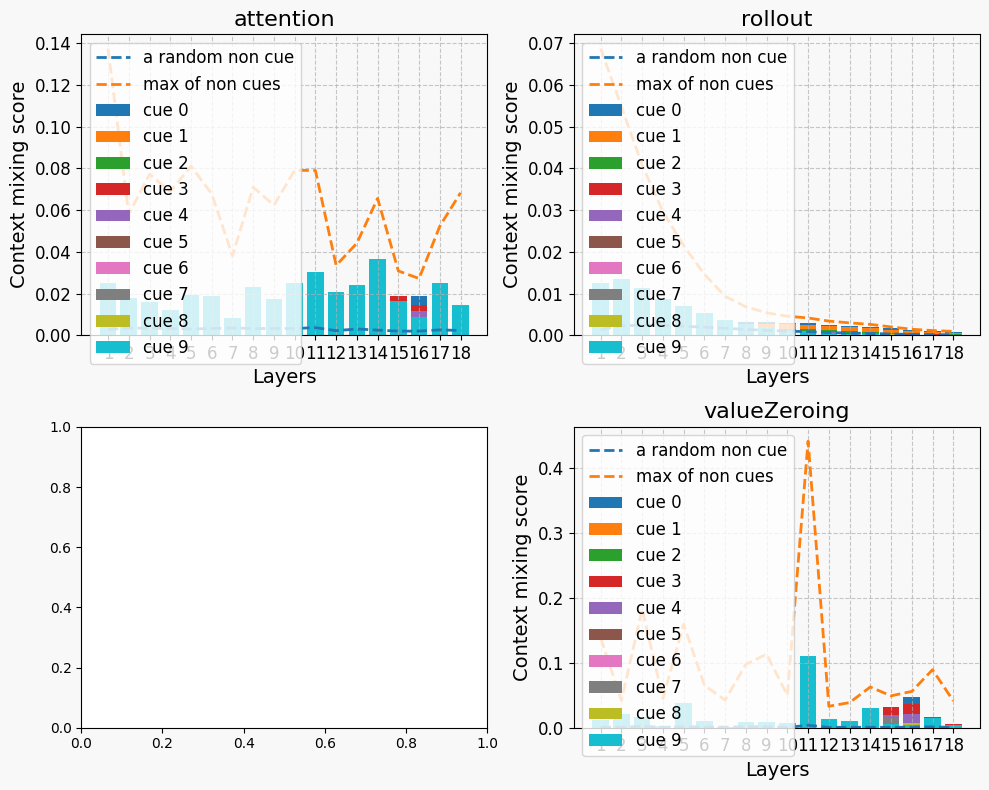

In [533]:
plot_cm(df_equal)

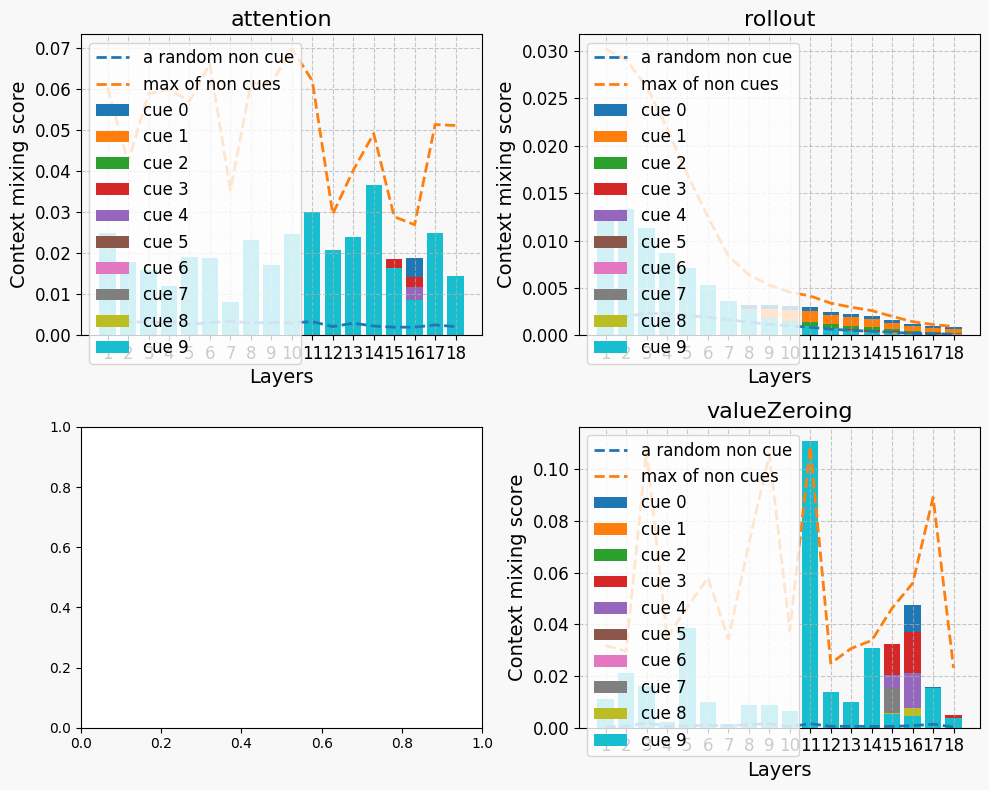

In [563]:
plot_cm(df_equal)

In [564]:
idx = 10
layer = 8
df_equal.iloc[idx]['masked_text']

"jens franke -lrb- born june 29 , 1964 -rrb- is a german mathematician . he holds a chair at the university of bonn 's hausdorff center for mathematics since 1992 . franke 's research has covered various problems of number theory , algebraic geometry and analysis on locally symmetric spaces . franke attended the university of jena , where he earned his ph.d. under hans triebel in 1986 . he was awarded the ems prize in 1992 , and the oberwolfach prize in 1993 . in recent years , franke worked on an implementation of the number field sieve algorithm for prime decomposition . in may 2007 , he and"

In [565]:
df_equal.iloc[idx]['valueZeroing_cm_all_layers'].size(1)

158

In [569]:
max_cm_idx = df_equal.iloc[idx]['valueZeroing_cm_all_layers'][layer].argsort()[-3].item()
max_cm_idx

155

In [570]:
df_equal.iloc[idx]['valueZeroing_cm_all_layers'][layer][max_cm_idx]

tensor(0.0518)

In [571]:
tokenizer.decode(tokenizer(df_equal.iloc[idx]['masked_text'])['input_ids'][max_cm_idx])

' ,'

# Save figures

In [ ]:
for c in tqdm(range(2,11)):
    for model in ['roberta-base', 'finetuned-roberta']:
        applicable_cm_methods = ['attention', 'rollout', 'attentionNorm', 'valueZeroing']
        df = pd.read_pickle(f'results/{model}_gender_agreement_{c}.pkl')
        
        equality_condition = (df['target_word'] == df['model_top1_prediction'].astype(str).str.lower()) | (' '+df['target_word'] == df['model_top1_prediction'].astype(str).str.lower())
        df_equal = df.loc[equality_condition]
    
        # add mask token index to the resulted dataframe
        tokenizer = AutoTokenizer.from_pretrained('roberta-base')
        df_equal['mask_tokenIdx'] = df_equal.apply(lambda row: extract_mask_tokenIdx(row['masked_text'], tokenizer), axis=1)
        
        # add cue_words cm and also mean and max cm of nonCueWords to the resulted dataframe
        for cm in applicable_cm_methods:
            df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
                lambda row: extract_cueWords_cm(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes']), 
                axis=1
            )
        
            df_equal[f'{cm}_nonCueWordsCm_mean_all_layers'] = df_equal.apply(
                lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'mean', row['mask_tokenIdx']), 
                axis=1
            )
        
            df_equal[f'{cm}_nonCueWordsCm_max_all_layers'] = df_equal.apply(
                lambda row: extract_nonCueWords_stats(row[f'{cm}_cm_all_layers'], row['cues_tokenIdxes'], 'max', row['mask_tokenIdx']), 
                axis=1
            )
        # clear_output()
        
        # save thes figures to the pdf format
        for column in applicable_cm_methods:
            plot_cm(df_equal, columns=[column], filename=f'figs/all_cms_figs/{model}_{column}_{c}.pdf', save_legend=True)

/tmp/ipykernel_3748383/977724059.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_equal['mask_tokenIdx'] = df_equal.apply(lambda row: extract_mask_tokenIdx(row['masked_text'], tokenizer), axis=1)
/tmp/ipykernel_3748383/977724059.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_equal[f'{cm}_CueWordsCm_all_layers'] = df_equal.apply(
/tmp/ipykernel_3748383/977724059.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in